In [1]:
import os, glob, torch, torchvision, cv2, PIL, time, random
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# 5x: raw/flip/rotate/jitter/blur
CFG={'SEED' : 46,
     'IMG_SIZE' : 224,
     'AUGMENTATION' : 2,  # 1: ONLY flip / 2: 5가지 다
     'TEST_PORTION' : 0.5,  # Test set 비율 (0.1 or 0.2)
     'CONTROL' : "NON_SJS",  # "NORMAL" or "NON_SJS"
     'gland' : "SMG_",  # "PTG_" or "SMG_"
     'THRESHOLD': 0.8,
     'BATCH_SIZE' : 64}

In [5]:
control = CFG["CONTROL"]
seed = CFG["SEED"]

if CFG["AUGMENTATION"] == 1:
    augmentation = "2x"
else:
    augmentation = "5x"

if CFG["TEST_PORTION"] == 0.1:
    test_portion = "test10"
elif CFG["TEST_PORTION"] == 0.2:
    test_portion = "test20"
elif CFG["TEST_PORTION"] == 0.5:
    test_portion = "test50"

if CFG["gland"] == "PTG_":
    gland = "PG"
else:
    gland = "SG"

model1_save_path = f"C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_Res)_seed{seed}.pt"
model2_save_path = f"C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_VGG)_seed{seed}.pt"
model3_save_path = f"C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_Inception)_seed{seed}.pt"

In [6]:
print(model1_save_path)  # 돌리기 전에 save_path 제대로 불러왔는지 확인하기
print(model2_save_path)
print(model3_save_path)

C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/NON_SJS_save_path/NON_SJS_5x_test50(SG_Res)_seed46.pt
C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/NON_SJS_save_path/NON_SJS_5x_test50(SG_VGG)_seed46.pt
C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/NON_SJS_save_path/NON_SJS_5x_test50(SG_Inception)_seed46.pt


In [7]:
# 파일 경로 가져오기
# PG: Parotid Gland (귀밑샘)
# SG: Submandibular Gland (턱밑샘)
def GET_PATH(path, control_group, gland):
    # NON_SJS: 240, SJS: 226
    control_dict, sjs_dict = dict(), dict()
    control_label, sjs_label = [], []

    for diagnosis in os.listdir(path):
        if diagnosis == control_group or diagnosis == 'SJS':
            diagnosed_path = path + diagnosis + f"/"
            diagnosed_list = os.listdir(diagnosed_path)  # DIAGNOSED group 환자번호를 LIST로 저장
            for i in range(len(diagnosed_list)):
                curr_ID = diagnosed_list[i]  # 현재 DIAGNOSED group 환자번호
                curr_images = []  # 현재 환자번호의 모든 사진을 LIST로 저장
                curr_path = diagnosed_path + curr_ID + f"/"  # 현재 환자번호 파일 경로
                for img in os.listdir(curr_path):  # 현재 환자번호의 모든 사진 반복
                    if gland in img:
                        curr_images.append(f"{curr_path}{img}")  # 현재 환자번호의 모든 사진 경로를 LIST로 저장
                if diagnosis == control_group:
                    control_dict[curr_ID] = curr_images
                    control_label.append(np.array([0,1]))
                elif diagnosis == "SJS":
                    sjs_dict[curr_ID] = curr_images
                    sjs_label.append(np.array([1,0]))
    
    return control_dict, sjs_dict, control_label, sjs_label

In [8]:
root_path = f"C:/Users/PC00/Desktop/Project2/AICOSS/PERSON/"
control_dict, sjs_dict, control_label, sjs_label = GET_PATH(root_path, CFG["CONTROL"], CFG['gland'])

In [9]:
print(f"TOTAL: {len(control_dict) + len(sjs_dict)}")
print(f"CONTROL: {len(control_dict)}")
print(f"SJS: {len(sjs_dict)}")

TOTAL: 466
CONTROL: 240
SJS: 226


In [10]:
preprocessing = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, whole, label, transform=None):
        self.whole = whole
        self.ID_list = list(whole.keys())
        self.label = label
        self.empty_count = 0
        self.transform = transform
    
    def __len__(self):  # 환자 총 인원 수
        return len(self.whole)
    
    def __getID__(self, idx):
        return self.ID_list[idx]
    
    def __get_pathlist__(self, idx):
        ID = self.__getID__(idx)
        return self.whole[ID]
    
    def __get_img__(self, idx):
        path_list = self.__get_pathlist__(idx)
        size = len(path_list)
        img = torch.zeros((3, 224, 224))
        if size == 0:
            self.empty_count += 1
        elif size != 0:
            for i in range(size):
                curr_img = self.transform(PIL.Image.open(path_list[i]))
                img = img + curr_img
            img = img/size

        return img  # 환자의 모든 사진을 concatenate한 뒤 평균 낸 이미지
    
    def __getitem__(self, idx):
        img = self.__get_img__(idx)
        if torch.sum(img).item() == 0:
            label = np.array([0,0])
        else:
            label = self.label[idx]
        
        return img, torch.from_numpy(label)

In [11]:
control_dataset = CustomDataset(control_dict, control_label, preprocessing)
sjs_dataset = CustomDataset(sjs_dict, sjs_label, preprocessing)
dataset = control_dataset + sjs_dataset

In [12]:
import timm

class Model1(nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        
        return x

class Model2(nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        self.model = timm.create_model('vgg16_bn', pretrained=True)
        self.model.head.fc = nn.Linear(in_features=4096, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        
        return x

class Model3(nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        self.model = timm.create_model('inception_v3', pretrained=True)
        self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        
        return x

c:\Users\PC00\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
model1 = Model1().to(device)
model2 = Model2().to(device)
model3 = Model3().to(device)

In [14]:
def test_loop(dataloader, model1, model2, model3, model1_path, model2_path, model3_path):
    model1.load_state_dict(torch.load(model1_path))
    model2.load_state_dict(torch.load(model2_path))
    model3.load_state_dict(torch.load(model3_path))
    model1.eval()
    model2.eval()
    model3.eval()

    pred_control=[]
    label_control=[]
    pred_sjs=[]
    label_sjs=[]

    pred=[]
    label=[]

    for (X, y) in dataloader:
        X = X.to(device).float()  # BATCH=1: 배치 한 번당 이미지 한 개
        y = y.to(device).float()

        X_np = X.cpu().detach().numpy()
        flag = np.sum(X_np)

        if flag == 0:
            continue

        for t in y:
            label.append(t.detach().tolist())
            label_control.append(t[1].detach().tolist())
            label_sjs.append(t[0].detach().tolist())

        output1 = model1(X)
        output2 = model2(X)
        output3 = model3(X)
        
        """Mean value Ensemble (START)"""
        # output = (output1+output2+output3)/3

        # for o in output:
        #     pred.append(o.detach().cpu().tolist())
        #     pred_control.append(o[1].detach().cpu().tolist())
        #     pred_sjs.append(o[0].detach().cpu().tolist())
        """Mean value Ensemble (END)"""

        """Maximum value voting (START)"""
        # ctr_arr = np.array((output1.cpu().detach().numpy()[0][1], output2.cpu().detach().numpy()[0][1], output3.cpu().detach().numpy()[0][1]))
        # sjs_arr = np.array((output1.cpu().detach().numpy()[0][0], output2.cpu().detach().numpy()[0][0], output3.cpu().detach().numpy()[0][0]))
        # ctr_idx = np.argmax(ctr_arr)
        # sjs_idx = np.argmax(sjs_arr)
        # output = [sjs_arr[sjs_idx], ctr_arr[ctr_idx]]

        # pred.append(output)
        # pred_control.append(output[1])
        # pred_sjs.append(output[0])
        """Maximum value voting (END)"""

        """Hard voting (START)"""
        # argue = 0
        # sjs_result, control_result = [], []

        # sjs1, control1 = output1.cpu().detach()[0]
        # sjs2, control2 = output2.cpu().detach()[0]
        # sjs3, control3 = output3.cpu().detach()[0]
        # sjs_list = [sjs1, sjs2, sjs3]
        # control_list = [control1, control2, control3]

        # for i in range(len(sjs_list)):
        #     if sjs_list[i]>control_list[i]:
        #         argue += 1
        #         sjs_result.append(sjs_list[i])
        #         control_result.append(0)
        #     else:
        #         sjs_result.append(0)
        #         control_result.append(control_list[i])

        # if argue != 0:
        #     sjs_out = np.sum(np.array(sjs_result))/argue
        #     if (3-argue) > 0:
        #         control_out = np.sum(np.array(control_result))/(3-argue)
        #     else:
        #         control_out = np.sum(np.array(control_result))
        #     output = np.array([sjs_out, control_out])
        # else:
        #     sjs_out = 0
        #     control_out = np.sum(np.array(control_result))/3
        #     output = np.array([sjs_out, control_out])
        
        # pred.append(output)
        # pred_control.append(output[1])
        # pred_sjs.append(output[0])
        """Hard voting (END)"""

        """Thresholding (START)"""

        th = CFG["THRESHOLD"]

        output = (output1+output2+output3)/3
        for o in output:
            if o[0] >= th:
                pred.append(np.array([1,0]))
            else:
                pred.append(np.array([0,1]))

        """Thresholding (END)"""

    return label_control, label_sjs, pred_control, pred_sjs, np.array(label), np.array(pred)

In [15]:
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
_, _, _, _, label, pred = test_loop(test_dataloader, model1, model2, model3, model1_save_path, model2_save_path, model3_save_path)

In [16]:
test_control, test_sjs = 0, 0
for (X, y) in test_dataloader:
    X_np = X.cpu().detach().numpy()
    flag = np.sum(X_np)

    if flag == 0:
        continue
    for t in y:
        if t[1] == torch.Tensor([1]):
            test_control += 1
        else:
            test_sjs += 1

print(test_control)
print(test_sjs)

189
216


<Axes: >

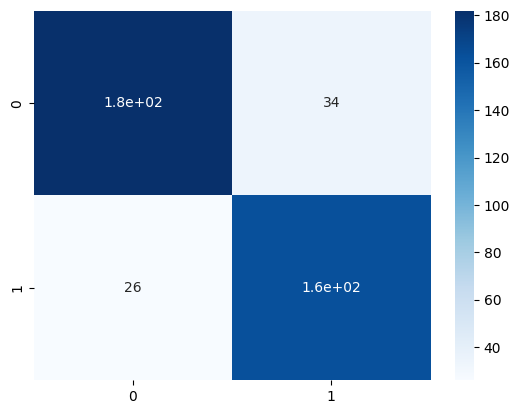

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

OH_pred = []

for vector in pred:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []

for vector in label:
    OH_label.append(np.argmax(vector, axis=0))

cm = confusion_matrix(OH_label, OH_pred)
plt.xlabel('Prediction')
plt.ylabel('Label')
sns.heatmap(cm, annot=True, cmap='Blues')

In [18]:
sjs_correct, control_correct = 0, 0
for idx in range(len(pred)):
    sjs_correct += 1 if (np.argmax(pred[idx])==0 and np.argmax(label[idx])==0) else 0
    control_correct += 1 if (np.argmax(pred[idx])==1 and np.argmax(label[idx])==1) else 0

print(control_correct)
print(sjs_correct)

163
182


In [19]:
print(f"Sensitivity: {sjs_correct/test_sjs}")
print(f"Specificity: {control_correct/test_control}")
print(f"Accuracy: {(sjs_correct+control_correct)/(test_sjs+test_control)}")

Sensitivity: 0.8425925925925926
Specificity: 0.8624338624338624
Accuracy: 0.8518518518518519
